In [1]:
import seaborn as sns

sns.set_theme(
    rc={"axes.spines.top": False, "axes.spines.right": False, "figure.autolayout": True},
    style="ticks",
)

# Plotting CMB & foreground model

In this tutorial, we will see how to access the foreground model from `MFLike` and how to plot its components in comparison with the CMB theory spectra. To avoid duplicating code, we load the first [tutorial](tutorial_loading.ipynb) of this serie. This way we have access to the `MFLike` instance through the variable `mflike`.

In [2]:
%run tutorial_loading.ipynb

     Numpy : 1.24.3
Matplotlib : 3.9.0
      CAMB : 1.5.4
    Cobaya : 3.5.4
[install] Installing external packages at '/tmp/LAT_packages'


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).



likelihood:mflike.TTTEEE

[install] Checking if dependencies have already been installed...
[install] External dependencies for this component already installed.
[install] Doing nothing.

* Summary * 

[install] All requested components' dependencies correctly installed at /tmp/LAT_packages
[camb] `camb` module loaded successfully from /home/serenagiardiello/anaconda3/envs/mflike/lib/python3.10/site-packages/camb
[mflike.ttteee] Number of bins used: 3087
[mflike.ttteee] Initialized!


## Plotting CMB power spectra



We can get the $D_\ell$s from `camb` using `cobaya` interface (the call of `logposterior` method is needed to trigger the $D_\ell$ computation).

In [3]:
model.logposterior({})
dls_cmb = model.theory["camb"].get_Cl(ell_factor=True)

Let's plot the different spectra on the default multipole range used by `MFLike`.

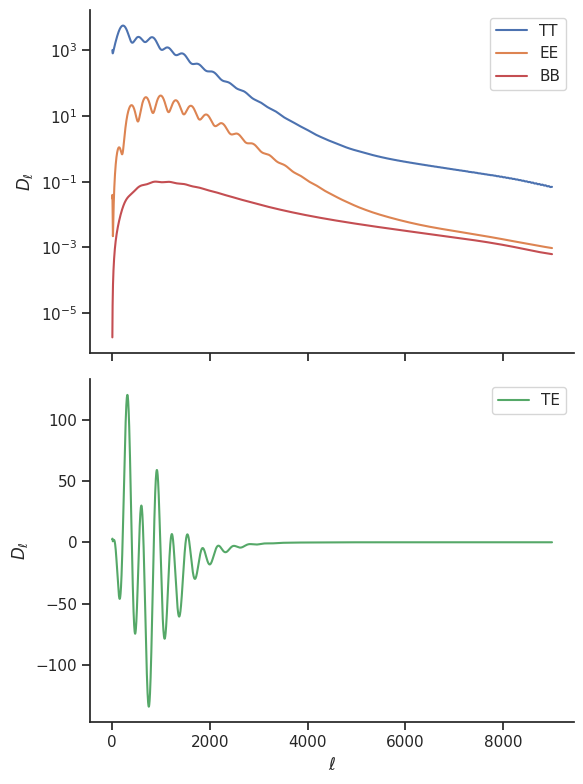

In [4]:
import matplotlib.pyplot as plt

ell = mflike.l_bpws

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
for i, mode in enumerate(["tt", "ee", "te", "bb"]):
    ax = axes[1] if mode == "te" else axes[0]
    ax.plot(ell, dls_cmb[mode][ell], f"-C{i}", label=mode.upper())

for ax in axes:
    ax.set_ylabel(r"$D_\ell$")
    ax.legend()
axes[0].set_yscale("log")
axes[1].set_xlabel(r"$\ell$");

## Plotting foregrounds



`MFLike` foreground model can be accessed through the `get_foreground_model` function of the `BandpowerForeground` instance. In principle, we can generate a foreground model at higher $\ell$ than the theory through the `ell` argument; here we keep the same $\ell$ range to plot the foregrounds with the theory in the next cell.

In [5]:
foreground_model = model.theory["mflike.BandpowerForeground"]
fg_models =  foreground_model.get_foreground_model(ell=ell, **fg_params)

We can then plot theory and foregrounds in a triangle plot given the combinations of cross-frequencies. In the following cell we are just making some adjustments on the foreground components to plot `tSZ` and `cibc` autospectrum and their cross correlation separately. 

In [6]:
import copy

components = copy.deepcopy(foreground_model.components)
components["tt"].remove("tSZ_and_CIB")
components["tt"] += ["tSZ", "cibc", "tSZxCIB"]

Here we define the plotting function. In the following plots, the dashed lines represent the absolute value of negative spectra.

In [7]:
from itertools import product


def plot_spectra(mode):
    experiments = mflike.experiments
    nexperiments = len(experiments)
    fig, axes = plt.subplots(nexperiments, nexperiments, sharex=True, sharey=True, figsize=(10, 10))

    for i, cross in enumerate(product(experiments, experiments)):
        idx = (i % nexperiments, i // nexperiments)
        ax = axes[idx]
        if idx in zip(*np.triu_indices(nexperiments, k=1)):
            fig.delaxes(ax)
            continue

        ax.plot(ell, fg_models[mode, "all", cross[0], cross[1]], color="k")
        for compo in components[mode]:
            fg_model = fg_models[mode, compo, cross[0], cross[1]]
            if np.any(fg_model < 0):
                ax.plot(ell, np.abs(fg_model), ls="--")
            else:
                ax.plot(ell, fg_model)

        if mode != "te":
            ax.plot(ell, dls_cmb[mode][ell], color="gray")
        else:
            ax.plot(ell, np.abs(dls_cmb[mode][ell]), color="gray", ls="--")
        title = f"{cross[0].split('_')[-1]}x{cross[1].split('_')[-1]} GHz"
        ax.legend([], title=title)
        ax.set(yscale="log", ylim=(0.001, 10_000) if mode == "tt" else None)

    comp_name = copy.deepcopy(components)
    comp_name["tt"] = ["|tSZxCIB+CIBxtSZ|" if n == "tSZxCIB" else n for n in comp_name["tt"]]
    for i in range(nexperiments):
        axes[-1, i].set_xlabel("$\ell$")
        axes[i, 0].set_ylabel("$D_\ell$")
    fig.legend(
        ["all"] + comp_name[mode],
        title=mode.upper(),
        labelcolor="linecolor",
        handlelength=0,
        bbox_to_anchor=(0.6, 1),
    )

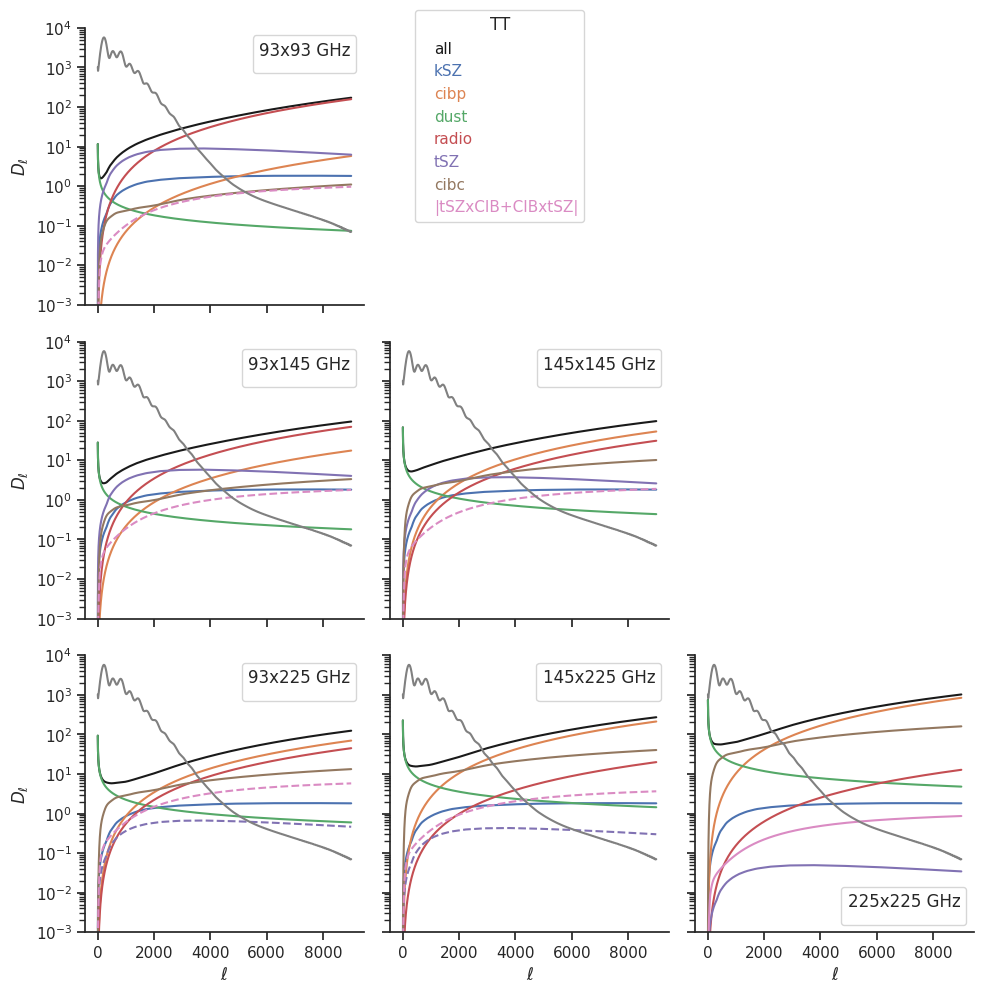

In [8]:
plot_spectra("tt")

We can also plot the `ee` or `te` modes with the argument of the plotting function, to see the contribution from radio and dust components

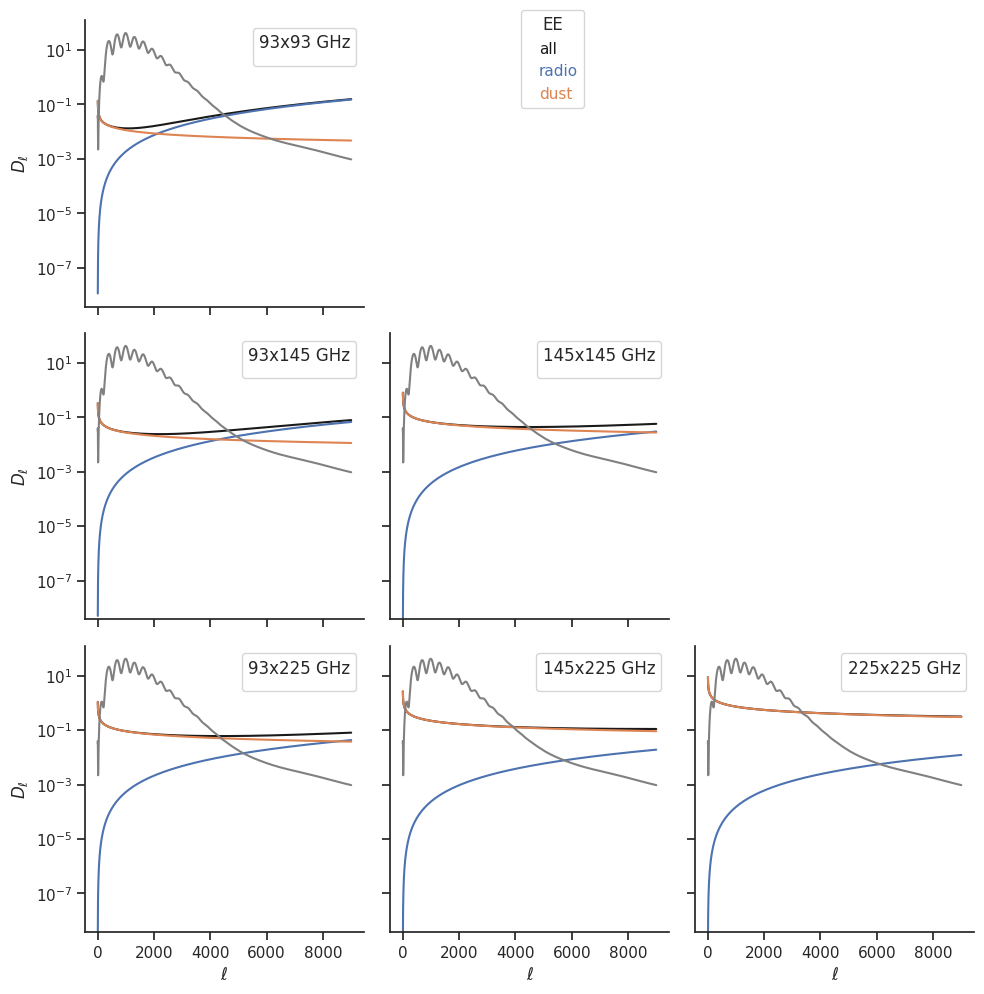

In [9]:
plot_spectra("ee")

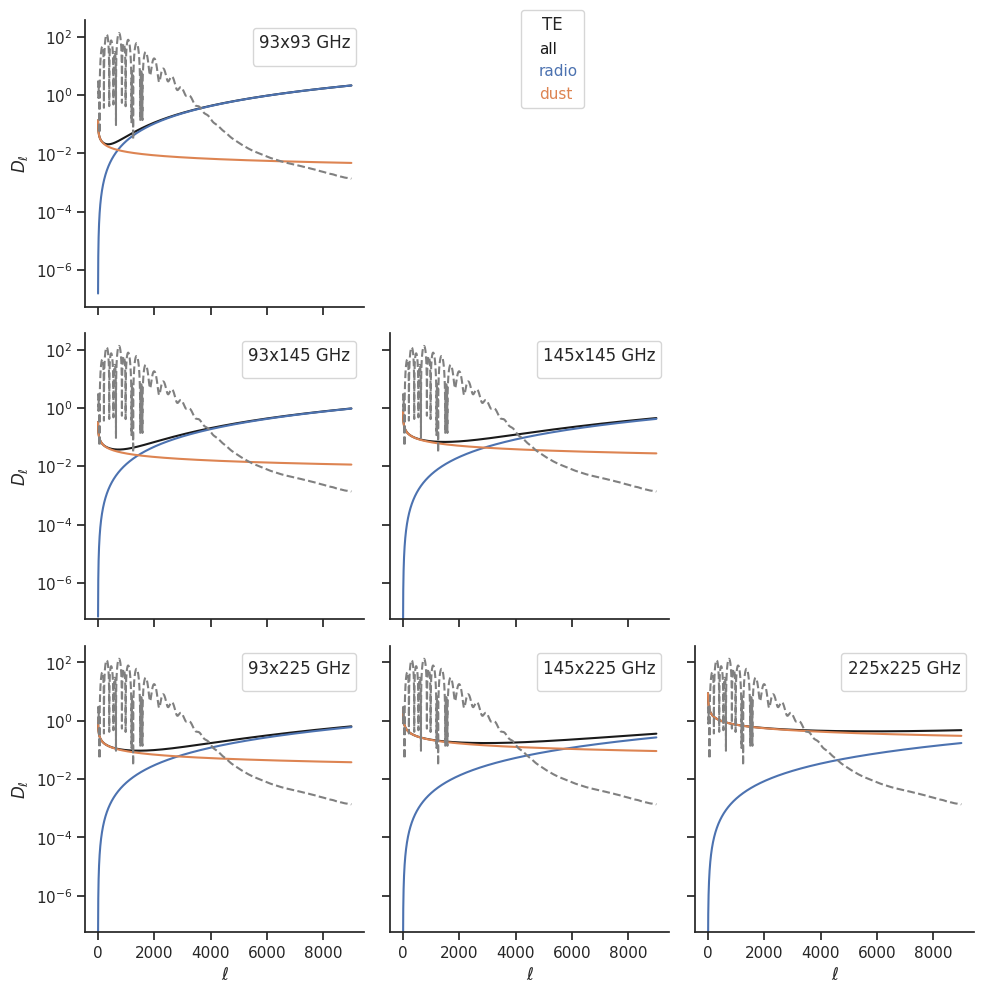

In [10]:
plot_spectra("te")